#Model Selection and Validation
By Chris Fenaroli, Max Margenot, and Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---
Linear regression is a technique that models the relationship between a set of independent variables $X_1,\ldots, X_k$ and a dependent outcome variable $Y$. Simple linear regression with two variables allows us to determine which linear model of the form $Y = \beta_0 + \beta_1 X$ best explains the data, while a multiple linear regression allows for the dependent variable to be a linear function of multiple independent variables $X_1,\ldots, X_k$: 

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_k X_k + \epsilon_i $$

More background information on regressions can be found in the [simple linear regression](https://www.quantopian.com/lectures#Linear-Regression) and [multiple linear regression](https://www.quantopian.com/lectures#Multiple-Linear-Regression) lectures.

In many cases, choosing which explanatory variables to include in a model is not trivial. If you include too many variables $X_1,\ldots, X_k$ you risk overfitting and multicollinearity (correaltion of explanatory variables) which would invalidate your regression results. With too few variables you risk excluding interactions. **Model selection** is the process of determining which combination of explanatory variables maximizes explanatory power and minimizes complexity. 

Once we have chosen our model fitted the data using an estimation method like OLS, it would be useful to quantify just how "good" our end-result model is. But what exactly makes a model "good"? Is it how well it fits the data? It's simplicity/complexity? Or is it how well it performs when applied to out-of-sample data? **Model validation** is the process of determining how "good" a model is and whether it is a satisfactory explanation for the given data.

In [852]:
# Import libraries
import numpy as np
import pandas as pd
from statsmodels import regression
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

# Model Selection

When presented with many possible explanatory variables, choosing which to include in a regression model can be a difficult task. Luckily, there exists a variety of strategies and criteria that simplify model selection. 

As an example, let's attempt to model the US unemployment rate with US inflation rate, QQQ NASDAQ-100 index, IWM Russel 2000 index, gold prices, and USD vs. EUR exchange rate as potential explanatory variables. All of these macro indicators are available as free [Quantopian Data Feeds](https://www.quantopian.com/data).

Let's begin by pulling the above as Blaze expressions.

In [994]:
from quantopian.interactive.data.quandl import fred_unrate as unemployment_bz
from quantopian.interactive.data.quandl import rateinf_inflation_usa as inflation_bz
from quantopian.interactive.data.quandl import bundesbank_bbk01_wt5511 as gold_bz
from quantopian.interactive.data.quandl import currfx_usdeur as fx_bz

import blaze as bz
from odo import odo

Now let's migrate the data into Pandas series using `asof_date` as our index keeping in mind that:

* Both inflation and unemployment data have one month intervals, so data index intervals cannot be anything smaller than monthly
* Unemployment data is released at the start of the month after the relevant month and inflation rate data is released ~3 weeks after so we must shift both back a month from the asof_date to prevent look-ahead bias
* Gold prices must be shifted back one day from asof_date to prevent look-ahead bias
* QQQ and IWM pricing data only goes back to 2002, so we can only consider data from 2002 on


In [1026]:
# Start date dictated by QQQ and IWM
start = '2002-01-01'
end = '2017-01-01'

# Sample period will be 2002-2012, saving 2012-2017 for model validation
s = '2002-01-01'
e = '2012-01-01'

index = pd.date_range(start=start, end = end, freq= 'MS')

# Adjusting data along points mentioned above and putting in Pandas series
unemployment = odo(unemployment_bz, pd.DataFrame).set_index(['asof_date']).shift().loc[index].ffill()['value'][1:]
inflation = odo(inflation_bz, pd.DataFrame).set_index(bz.compute(inflation_bz.asof_date) + pd.Timedelta('1 days')).shift().loc[index].ffill()['value'][1:]
gold = odo(gold_bz[gold_bz.asof_date >= start], pd.DataFrame).set_index(['asof_date'])['value'].sort_index().asof(index).ffill()[1:]
fx = odo(fx_bz, pd.DataFrame).set_index(['asof_date'])['rate'].sort_index().asof(index).ffill()[1:]
qqq = get_pricing('QQQ', start_date=start, end_date=end, fields = 'price').asof(index).ffill()[1:]
iwm = get_pricing('IWM', start_date=start, end_date=end, fields = 'price').asof(index).ffill()[1:]

Now we have data for on independent variable:

$$ Y_u: unemployment $$

And 5 predictor variables:

$$X_q: QQQ \:\:\:\:\: X_i: inflation \:\:\:\:\: X_r: IWM \:\:\:\:\: X_f: FX Euro rate \:\:\:\:\: X_g: gold$$

The next step is to figure out which predictors to include in our model. We could include every single predictor we have, but we would not be sure if every predictor was significant. Adding many insignificant predictors causes a few different issues. If there are more predictors there is a larger chance that the predictors themselves are correalted with each other which would lead to regression model instability and invalidate our results. Furthermore, including many regressors hurts the predictive power of a model. A solution might be to include as few variables as possible, but we would likely exclude some explanatory effects this way. Let's look at some ways to find this balance and determine which variables to include.

## Model Selection Criteria

There exist a number of metrics we can use to asses the relative and absolute strength of a specfic model. The ones we will focus on are $R^2$, adjusted $R^2$, BIC, and AIC.

### Coefficient of Determination ($R^2$)

The coefficient of determination, or $R^2$, is a metric that tells us the proportion of in-sample variance 'explained' by a certain model. For example, an $R^2$ of 0.9 tells us that the magnitude of the model residual variance is about 90% of that of the sample data. The formula for $R^2$ is:

$$R^2 = \frac{SS_{reg}}{SS_{total}} = 1 - \frac{\sum_{i=1}^{n} (Y_i - \hat{Y_i})^2}{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}$$

Where $Y_i$ are sample response values, $\hat{Y_i}$ are the response values predicted by the model and $\bar{Y}$ is the sample mean response.



One major drawback of $R^2$ in model selection is that as the number of explanatory variables increases, $R^2$ will always also increase or stay the same, even if the incremental variables are not adding much predictive insight. To illustrate this, let's find the $R^2$ of five unemployment models, each model having one more predictor than the next. We will do this by defining a function that takes predictor variables $X_1,\ldots, X_k$ and an independent variable $Y$, runs a regression, and calculates $R^2$ using the `model.rsquared` attribute.

In [1055]:
def rsquared(X,Y):
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    return model.rsquared

# Defining variables, making sure to keep data within the sample period [:e]
Y = unemployment[:e]
X = [qqq[:e], inflation[:e], iwm[:e], fx[:e], gold[:e]]
X_str = ['qqq', 'inflation', 'iwm', 'fx', 'gold']

print '------ R Squared Values ------'
print '1 predictor:', rsquared(np.column_stack(X[:1]), Y)
print '2 predictors:', rsquared(np.column_stack(X[:2]), Y)
print '3 predictors:', rsquared(np.column_stack(X[:3]), Y)
print '4 predictors:', rsquared(np.column_stack(X[:4]), Y)
print '5 predictors:', rsquared(np.column_stack(X[:5]), Y)

 ------ R Squared Values ------
1 predictor: 0.124499233139
2 predictors: 0.459882090695
3 predictors: 0.700574522302
4 predictors: 0.734219660452
5 predictors: 0.875758340212


As we can see, increasing the number of predictors inflates the $R^2$ output. If we only went by the $R^2$ prediction criteria, the best model would always be the one with the most predictor variables. This invalidates $R^2$ as a model selection criteria for models with different amounts of predictor variables.

###  $\bar{R}^2$ (Adjusted $R^2$)

Because regular $R^2$ becomes inflated as more variables are added we cannot use $R^2$ alone for model selection. To account for this effect, there exists an alternate version of $R^2$ which includes a penalty for adding more variables. The formula is below, where $p$ is the number of predictor variables, and $n$ is the sample size:

$$ \bar{R}^2 = 1-(1-R^2)\frac{n-1}{n-p-1} $$

Let's repeat the expirement above, this time using $\bar{R}^2$, to see if it still inflates as more predictors are added.

In [1056]:
def rsquared_adj(X,Y):
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    return model.rsquared_adj

print '------ Adj R Squared Values ------'
print '1 predictor:', rsquared_adj(np.column_stack(X[:1]), Y)
print '2 predictors:', rsquared_adj(np.column_stack(X[:2]), Y)
print '3 predictors:', rsquared_adj(np.column_stack(X[:3]), Y)
print '4 predictors:', rsquared_adj(np.column_stack(X[:4]), Y)
print '5 predictors:', rsquared_adj(np.column_stack(X[:5]), Y)

------ Adj R Squared Values ------
1 predictor: 0.117079735115
2 predictors: 0.45064930592
3 predictors: 0.692830759948
4 predictors: 0.724975126903
5 predictors: 0.870309144607


The $\bar{R}^2$ are similar to the $R^2$ values, however we can see that the values are slightly smaller due to the predictor penalty. $\bar{R}^2$ should always be used when comparing models with different amounts of predictors to avoid the predictor inflation effect of $R^2$.

### Akaike and Bayesian Information Criterion (AIC and BIC)



$R^2$ and $\bar{R}^2$ provide absolute measures on the quality on a model, meaning they can be calculated on any single regression model. They tell you how "good" a model is on its own on a scale of 0 to 1. 

AIC and BIC provide relative measures of quality and are calculated with an underlying selection pool of models. Instead  of yeidling a metric with an absolute scale like $R^2$ and $\bar{R}^2$, they return values for every model in the selection pool and determining model quality requires looking at all of the values and comparing them.

AIC is calculated along the following formula: 

$$ AIC = 2p + nLog(SS_{resid}/n) $$

BIC is calculated similarly:

$$ AIC = ln(n) \cdot p  + nLog(SS_{resid}/n) $$

Where $SS_{resid}$ is the sum of squared residuals $\sum_{i=1}^{n}(Y_i - \hat{Y_i})^2$

Let's use AIC and BIC to compare 5 simple linear regression models for unemployment. We will compute them using the `model.aic` and `model.bic` attributes.

In [1057]:
def AIC(X,Y):
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    return model.aic

def BIC(X,Y):
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    return model.bic

AICs = pd.Series([AIC(X[_],Y) for _ in range(5)])
BICs = pd.Series([BIC(X[_],Y) for _ in range(5)])

print "%-24s %-15s %-13s" % ('', 'AIC values:', 'BIC values:')
print "%-24s %-15s %-13s" % ('Y = b0 + b1*qqq', AICs[0], BICs[0])
print "%-24s %-15s %-13s" % ('Y = b0 + b1*inflation', AICs[1], BICs[1])
print "%-24s %-15s %-13s" % ('Y = b0 + b1*iwm', AICs[2], BICs[2])
print "%-24s %-15s %-13s" % ('Y = b0 + b1*fx', AICs[3], BICs[3])
print "%-24s %-15s %-13s" % ('Y = b0 + b1*gold', AICs[4], BICs[4])

                         AIC values:     BIC values:  
Y = b0 + b1*qqq          481.904294922   487.479278408
Y = b0 + b1*inflation    464.408261441   469.983244926
Y = b0 + b1*iwm          497.835819526   503.410803012
Y = b0 + b1*fx           488.599333286   494.174316772
Y = b0 + b1*gold         398.65240035    404.227383836


Now let's plot the AICs and BICs.

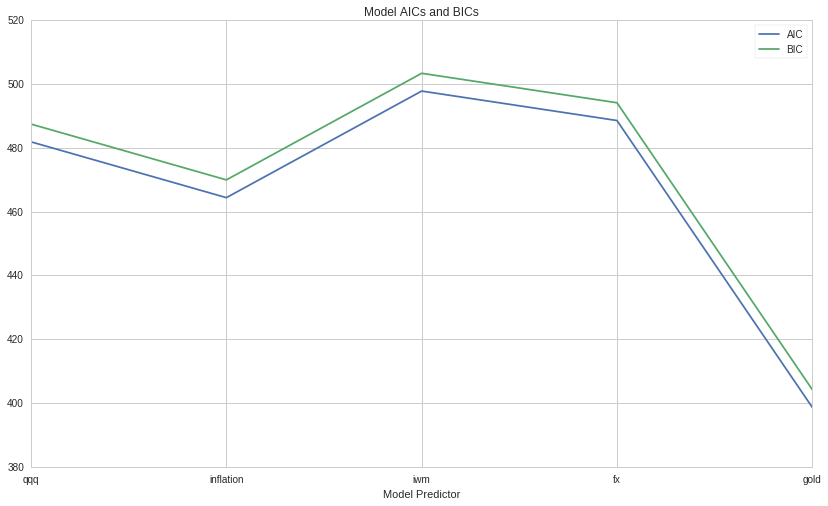

In [926]:
AICs.plot(title = 'Model AICs and BICs', label = 'AIC');
BICs.plot(label = 'BIC');
plt.xticks(range(5), X_str);
plt.xlabel('Model Predictor');
plt.legend();

The "best" model according to AIC and BIC is the one with the smallest value. In this case, both the Akaike and Bayesian information criterion point to the same conclusion; they are both at their minimum with the model $Y = b_0 + b_1 \cdot gold$ meaning gold is the best single predictor for the model on this sample

### AIC vs BIC

In this test the two criteria pointed to the same model as the best, but this is not always the case as the two criteria have a few key differences. 

* The BIC imposes a harsher penalty on additional regressors than the AIC does and will usually select "smaller" models with less parameters
* AIC is more suitable for selecting models that serve as the best predictors
* BIC is best used to select a model that best explains the behavior in-sample

## Selection Methods

Now that we have a handful of criteria to quantify model quality we need to have a method to cycle through and search for the possible models.

The first idea that might come to mind is to simply pool all possible models together and test them all. While this might work for a situation in which there are a small number of potential regressors, when dealing with big data sets and many possible predictors it becomes a more difficult issue. The number of predictor combinations begins to rise quickly as more possible predictors are added making cycling through every combination not possible.

### Step AIC/BIC

If the number of possible predictors large, the best for selecting the "best" is likely iterating through a stepwise linear regression. Broadly, the method builds a model by selecting regressors one at a time, at each step choosing the one that minimizes the model's AIC or BIC. The process ends when adding another variable can no longer decrease the AIC/BIC or when the algorithm exhausts the predictor set and there are no more potential predictors to add.

Let's use a step-forward AIC algorithm to select a set of unemployment predictors to use in our model. Some print statements have been added to show the iteration process but can and should be deleted if you would like to use the function elsewhere.

In [927]:
def forward_aic(response, data):
    # This function will work with pandas dataframes and series
    
    # Initialize some variables
    explanatory = list(data.columns)
    selected = pd.Series(np.ones(data.shape[0]), name="Intercept")
    current_score, best_new_score = np.inf, np.inf
    step = 1
    
    # Loop while we haven't found a better model
    while current_score == best_new_score and len(explanatory) != 0:
        
        
        scores_with_elements = []
        count = 0
        
        # For each explanatory variable
        for element in explanatory:
            # Make a set of explanatory variables including our current best and the new one
            tmp = pd.concat([selected, data[element]], axis=1)
            # Test the set
            result = regression.linear_model.OLS(response, tmp).fit()
            score = result.aic
            scores_with_elements.append((score, element, count))
            count += 1
        
        # Sort the scoring list
        scores_with_elements.sort(reverse = True)
        # Get the best new variable
        best_new_score, best_element, index = scores_with_elements.pop()
        print '--- Step', step, ' ---'
        step += 1
        print 'Current Best AIC:', current_score
        print 'Best New AIC:', best_new_score
        print 'Variable to Add:', best_element    
        
        if current_score > best_new_score:
            # If it's better than the best add it to the set
            explanatory.pop(index)
            selected = pd.concat([selected, data[best_element]],axis=1)
            current_score = best_new_score
            print 'Chosen Model Predictors:', selected.columns.values[1:], '\n'
        else:
            print 'Best new AIC did not beat current best. The new variable to add is rejected and the algorithm is finished.\n\n'

    # Return the final model
    return selected

In [928]:
# Reformatting the data to work with the forward_aic function
Y_series = pd.Series(Y).reset_index(drop=True)
data_df = pd.DataFrame(np.column_stack((X[0],X[1],X[2],X[3],X[4])), columns = X_str)

predictors = forward_aic(Y_series, data_df)
print 'Selected Predictors:', predictors.columns.values[1:]

--- Step 1  ---
Current Best AIC: inf
Best New AIC: 398.65240035
Variable to Add: gold
Chosen Model Predictors: ['gold'] 

--- Step 2  ---
Current Best AIC: 398.65240035
Best New AIC: 307.741249417
Variable to Add: iwm
Chosen Model Predictors: ['gold' 'iwm'] 

--- Step 3  ---
Current Best AIC: 307.741249417
Best New AIC: 258.210706106
Variable to Add: inflation
Chosen Model Predictors: ['gold' 'iwm' 'inflation'] 

--- Step 4  ---
Current Best AIC: 258.210706106
Best New AIC: 253.653929589
Variable to Add: qqq
Chosen Model Predictors: ['gold' 'iwm' 'inflation' 'qqq'] 

--- Step 5  ---
Current Best AIC: 253.653929589
Best New AIC: 255.596196199
Variable to Add: fx
Best new AIC did not beat current best. The new variable to add is rejected and the algorithm is finished.


Selected Predictors: ['gold' 'iwm' 'inflation' 'qqq']


The `forward_aic` algorithm selected gold prices, the IWM index, inflation rate, and the QQQ index as the most appropriate combination of predictors. The model is now:

$$ Y_{unrate} = \beta_0 + \beta_1 X_{gold} + \beta_2 X_{iwm} + \beta_3 X_{inflation} + \beta_4 X_{qqq} + \epsilon_i $$

Let's fit this model using OLS to determine the beta coefficients and graph both the model's prediction for unemployment and its actual values.

Intercept    7.180962
gold         0.003986
iwm         -0.093050
inflation   -0.386373
qqq          0.067445
dtype: float64


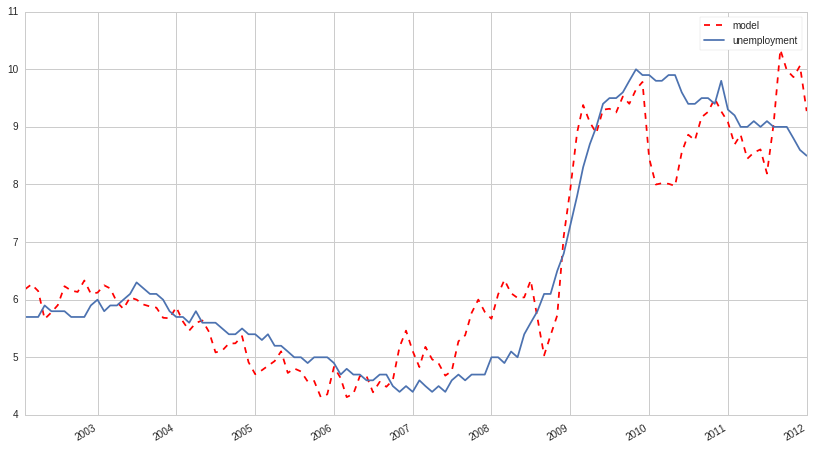

In [929]:
model = regression.linear_model.OLS(Y.reset_index(drop=True), predictors).fit()
theta = model.params
print theta
predictions = model.params[0] + model.params[1]*gold[s:e] + model.params[2]*iwm[s:e] + model.params[3]*inflation[s:e] + model.params[4]*qqq[s:e]

predictions.plot(label = 'model', linestyle = '--', c = 'r');
Y.plot(label = 'unemployment');
plt.legend();

At first glance the regression model seems decent, but further evaluation is required to determine it's validity.

# Model Validation

Now that we used model selection criteria and methods to find the most valuable combination of regressors, we now must determine whether this best model is acceptable. Because "best" is a relative term, it is possible that the best model does not explain the independent variable in a satisfactory way. As a result, more work needs to be done to ensure that our model is well-founded.

### $R^2$ and $\bar{R}^2$

As well as being criteria model selection, $R^2$ and $\bar{R}^2$ can also be used as model validation criteria. The intuition, formulas, and weaknesses detailed in the selection section still hold. However, in terms of validation they are additionally limited as they cannot  determine the accuracy of the form of the relationship, a vital part of a well-founded model. 

To illustrate this weakness we can run a linear regression on two datasets with very different forms. Both regressions have a similar $R^2$ value but only the second accurately represents the form of the data it is modeling.

R^2 of First Model: 0.671416768972
R^2 of Second Model: 0.67216727851


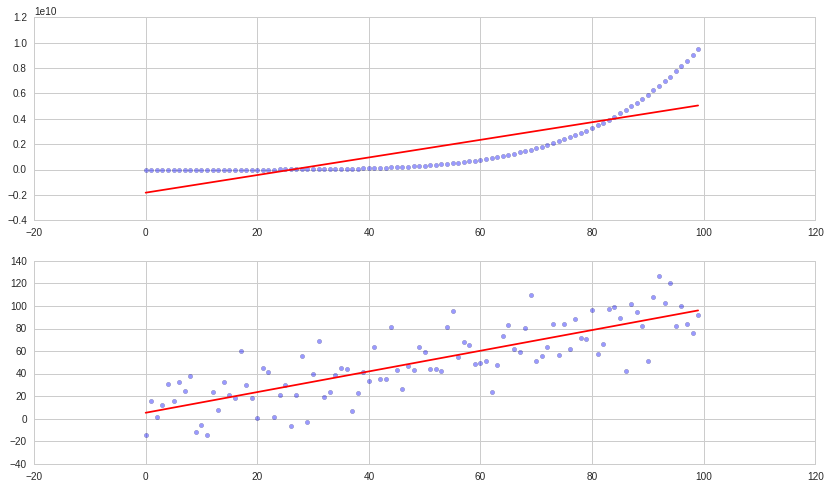

In [930]:
np.random.seed(13)
X = range(100)
Y1 = [x**5 for x in X]
Y2 = [x + 20*np.random.normal(0,1) for x in X]

model1 = regression.linear_model.OLS(Y1, sm.add_constant(X)).fit()
model2 = regression.linear_model.OLS(Y2, sm.add_constant(X)).fit()

print 'R^2 of First Model:', model1.rsquared
print 'R^2 of Second Model:', model2.rsquared

line1 = [model1.params[0] + model1.params[1]*x for x in X]
line2 = [model2.params[0] + model2.params[1]*x for x in X]

fig, axes = plt.subplots(nrows = 2, ncols = 1)

axes[0].plot(X, line1, c = 'r');
axes[0].scatter(X, Y1, alpha = 0.4);
axes[1].plot(X, line2, c = 'r');
axes[1].scatter(X, Y2, alpha = 0.4);

Clearly the second model best represents the data it was meant to model, but it has practically the same $R^2$ as the first. This illustrates the limitations of $R^2$ when it comes to determining model fit and predictive value.

Although it will not provide a complete picture, let's find the $R^2$ and $\bar{R}^2$ of our unemployment model:


In [931]:
print 'Unemployment Model R^2:', model.rsquared
print 'Unemployment Model Adjusted R^2:', model.rsquared_adj

Unemployment Model R^2: 0.875698551729
Unemployment Model Adjusted R^2: 0.871375023094


## Residual Analysis

A large portion of model validation has to do with studying the residuals of the regression in question. Residual analysis can help check that the basic assumptions of the linear model are satisfied. More information can be found in the [lecture on residauls analysis].

## Cross-Validation

Cross-validation is a technique used to determine how well a model will predict values outside of the sample used to select or fit it. In the case of our unemployment model, we used data from 2002 through 2012 to select our parameters. Now to ensure the accuracy of our model parameters (stored in `predictors`) we will employ a cross-validation technique known as *forward chaining* on the 2002-2012 data. We will leave the 2012-2017 data untouched for further validation methods later on.

Forward chaining cross-validation works by splitting the data up into $k$ equal sized partitions, and conducting an "out-of-sample test" for each partition. During each of these out-of-sample tests we will choose a training set and a testing set and use the training set to fit the model and the testing set to asses its performance. For time series data the training set must come before the testing set, and in the case of forward chaining the training set consists of all the data before the testing set. Forward chaining iterates through all possible testing sets and asses model performance in each.

In the case of our unemployment model, we will partition our 2002-2012 data into 10 yearly blocks. The first 3 iterations of a forward chaining test would be constructed as follows:


$$
\
 \text{Iteration } 1:  \overbrace{
    \underbrace{\textit{2002}}_\text{Training} +
    \underbrace{\textit{2003}}_\text{Testing}
   }^\text{First Trail-Test Pair}
 \
$$

$$
 \
 \text{Iteration } 2:  \overbrace{
    \underbrace{\textit{2002 & 2003}}_\text{Training} +
    \underbrace{\textit{2004}}_\text{Testing}
   }^\text{Second Trail-Test Pair}
 \
$$

$$
 \
 \text{Iteration } 3:  \overbrace{
    \underbrace{\textit{2002 & 2003 & 2004}}_\text{Training} +
    \underbrace{\textit{2005}}_\text{Testing}
   }^\text{Third Trail-Test Pair}
 \
$$

<center>
.  .  .
</center>


The end result is a single performance statistic, usually the  mean squared error (MSE) or adjusted $R^2$ of the model in the testing set averaged from across all of the iterations. Let's implement a forward chaining model-validation test on our unemployment model using adjusted MSE as our model prediction quality metric.

In [1058]:
Y = unemployment[:e]
X = [qqq[:e], inflation[:e], iwm[:e], fx[:e], gold[:e]]

# Our step AIC algorithm selected all predictors except for fx_rate
predictors = pd.DataFrame(data = [qqq[:e], inflation[:e], iwm[:e], gold[:e]], index = ['qqq', 'inflation', 'iwm', 'gold']).T

# Setting partition dates to the first day of every year 2002-2012
cutoff_dates = pd.date_range(start = '2002-01-01', end = '2012-01-01', freq = 'AS')
n = len(cutoff_dates)

MSEs = []

for i in range(1,n-1):
    
    # Defining training and testing sets for each iteration, using yearly cutoff dates
    training_data = predictors.loc[cutoff_dates[0]:cutoff_dates[i]]
    testing_data = predictors.loc[cutoff_dates[i]:cutoff_dates[i+1]]
    
    # Fitting model within the training set
    fitted_theta = regression.linear_model.OLS(Y[cutoff_dates[0]:cutoff_dates[i]], sm.add_constant(training_data)).fit().params
    
    # Testing performance within the testing set
    testing_model = (fitted_theta[0] + fitted_theta[1] * testing_data['qqq'] + fitted_theta[2] * testing_data['inflation']
                     + fitted_theta[3] * testing_data['iwm'] + fitted_theta[4] * testing_data['gold'])
    
    # Caluclate Mean Squared Error for the model runnning on the testing set
    errors = Y[cutoff_dates[i]:cutoff_dates[i+1]]-testing_model
    df = len(testing_model) - len(predictors.columns) - 1
    MSE = np.sum([error**2 for error in errors])/df
    MSEs.append(MSE)
    
    print 'MSE in', cutoff_dates[i].year,':', MSE
    
print '\n\nAverage MSE across Iterations:', np.mean(MSEs)
print 'Average MSE Excluding 2009:', np.mean(MSEs[:6]+MSEs[7:])

MSE in 2003 : 0.0565831690527
MSE in 2004 : 0.653180823804
MSE in 2005 : 0.20938626572
MSE in 2006 : 0.56114441747
MSE in 2007 : 0.021279349198
MSE in 2008 : 2.0220023476
MSE in 2009 : 13.4768461212
MSE in 2010 : 3.51297688997
MSE in 2011 : 2.4009454556


Average MSE across Iterations: 2.54603831551
Average MSE Excluding 2009: 1.1796873398


Since unemployment usually is between 3 and 10 percent, a 2.5 MSE is large. However, we can also see that the a couple outliers around the 2009 recession led to this higher error. Excluding 2009, our average MSE would be 1.18, a more reasonable value.

## Out-of-Sample Validation

After conducting the forward chaining test we can be confident in the performance of our model within the time period of 2002-2012. So far in this lecture, all of the testing and development of this model has been done within this 10-year period. Working extensively within a single timeperiod can lead to overfitting.

### Overfitting

A model is overfit when it is trained so much that it models the random noise of the data instead of just the underlying relationship. Conducting out-of-sample tests and using cross-validation helps avoid overfitting. It is easy to have a model that looks perfect in-sample, but has little predictive value. To demonstrate the dangers of overfitting, look at the two models below. They both model the same data, but  `simple_model` is just a simple linear regression while  `complicated_model` includes high-order values of X. The result is that the second more complicated model looks better in-sample, but the first and more simple one explains the relationship better.

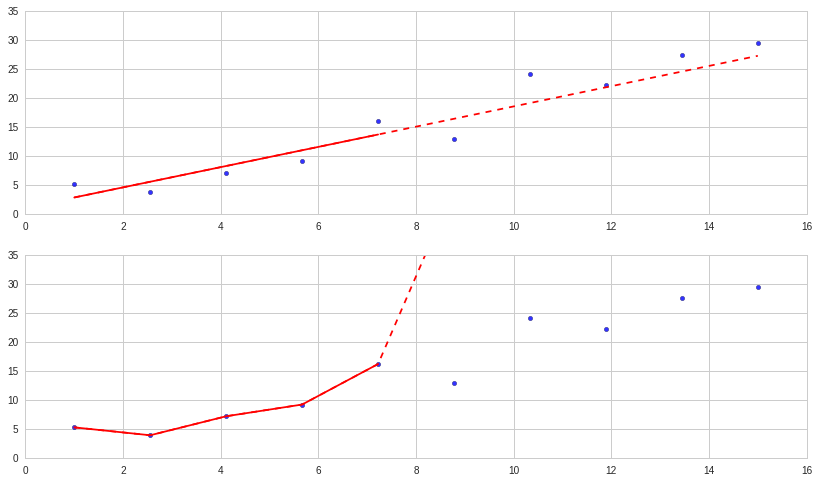

In [1080]:
np.random.seed(1)
X = np.linspace(1,15,10)
Y = [2*x + 2*np.random.normal(0,1) for x in X]

X2 = X**2
X3 = X**3
X4 = X**4

simple = regression.linear_model.OLS(Y[:len(X)/2], sm.add_constant(X[:len(X)/2])).fit().params
complicated = regression.linear_model.OLS(Y[:len(X)/2], sm.add_constant(np.column_stack([X[:len(X)/2],X2[:len(X)/2],X3[:len(X)/2],X4[:len(X)/2]]))).fit().params

simple_model = simple[0] + simple[1] * X
complicated_model = complicated[0] + complicated[1] * X + complicated[2] * X2 + complicated[3] * X3 + complicated[4] * X4                                   
                                            
fig, axes = plt.subplots(nrows = 2, ncols = 1)

axes[0].plot(X[:len(X)/2], simple_model[:len(X)/2], c = 'r');
axes[0].plot(X, simple_model, c = 'r', linestyle='--');
axes[0].scatter(X, Y, alpha = 0.8);
axes[1].plot(X[:len(X)/2], complicated_model[:len(X)/2], c = 'r');
axes[1].plot(X, complicated_model, c = 'r', linestyle='--');
axes[1].scatter(X, Y, alpha = 0.8);
plt.ylim(0,35);

For more information on overfitting, refer to the [Dangers of Overfitting Lecture](https://www.quantopian.com/lectures/the-dangers-of-overfitting).  

To see if our unemployment model is overfit let's conduct an out-of-sample validation test. We will use the 2002-2012 data to fit the model and then the 2012-2017 data to test it.

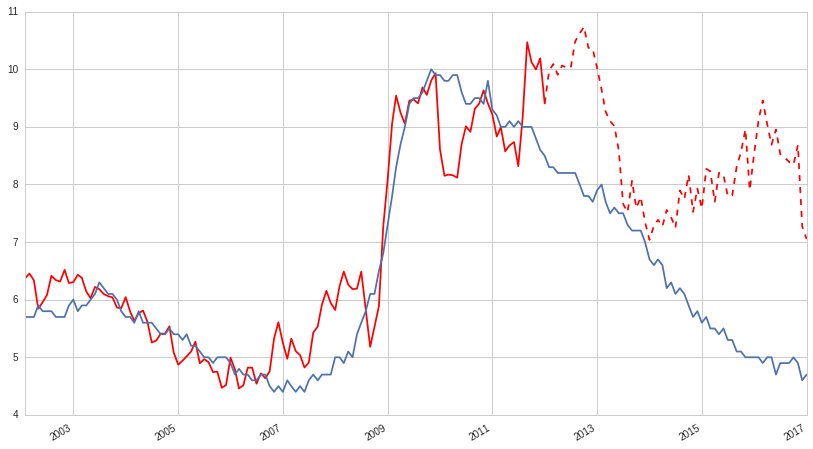

In [1081]:
Y = pd.Series(unemployment)
X_train = pd.DataFrame([qqq[:e], inflation[:e], iwm[:e], fx[:e], gold[:e]], columns = Y[:e].index, index = X_str).T
X_test = pd.DataFrame([qqq[e:], inflation[e:], iwm[e:], fx[e:], gold[e:]], columns = Y[e:].index, index = X_str).T


thetas = regression.linear_model.OLS(Y.loc[:e], sm.add_constant(X_train)).fit().params
model_insample = (thetas[0] + thetas[1] * X_train['qqq'] + thetas[2] * X_train['inflation']
                     + thetas[3] * X_train['iwm'] + thetas[5] * X_train['gold'])
model_outsample = (thetas[0] + thetas[1] * X_test['qqq'] + thetas[2] * X_test['inflation']
                     + thetas[3] * X_test['iwm'] + thetas[5] * X_test['gold'])

model_insample.plot(c = 'r');
model_outsample.plot(c = 'r', linestyle = '--');
Y.plot();

Out-of-sample our fitted model performs nowhere near as well as it does in-sample. Lets employ forward-chaining again, this time with 6 month partitions instead of yearly ones, on this 2012-2017 validation data to confirm the validity of our predictor selections.

In [967]:
Y = unemployment[e:]
X = [qqq[e:], inflation[e:], iwm[e:], fx[e:], gold[e:]]

# Our step AIC algorithm selected all predictors except for fx_rate
predictors = pd.DataFrame(data = [qqq[e:], inflation[e:], iwm[e:], gold[e:]], index = ['qqq', 'inflation', 'iwm', 'gold']).T

# Setting partition dates to the first day of every year 2002-2012
cutoff_dates = pd.date_range(start = '2012-01-01', end = '2017-01-01', freq = '6MS')
n = len(cutoff_dates)

MSEs = []

for i in range(1,n-1):
    
    # Defining training and testing sets for each iteration, using yearly cutoff dates
    training_data = predictors.loc[cutoff_dates[0]:cutoff_dates[i]]
    testing_data = predictors.loc[cutoff_dates[i]:cutoff_dates[i+1]]
    
    # Fitting model within the training set
    fitted_theta = regression.linear_model.OLS(Y[cutoff_dates[0]:cutoff_dates[i]], sm.add_constant(training_data)).fit().params
    
    # Testing performance within the testing set
    testing_model = (fitted_theta[0] + fitted_theta[1] * testing_data['qqq'] + fitted_theta[2] * testing_data['inflation']
                     + fitted_theta[3] * testing_data['iwm'] + fitted_theta[4] * testing_data['gold'])
    
    # Caluclate Mean Squared Error for the model runnning on the testing set
    errors = Y[cutoff_dates[i]:cutoff_dates[i+1]]-testing_model
    df = len(testing_model) - len(predictors.columns) - 1
    MSE = np.sum([error**2 for error in errors])/df
    MSEs.append(MSE)
    
    print 'MSE in', cutoff_dates[i].year,':', MSE
    
print '\n\nAverage MSE across iterations:', np.mean(MSEs)

MSE in 2012 : 0.23988877334
MSE in 2013 : 0.405434958749
MSE in 2013 : 0.0945991177613
MSE in 2014 : 0.779186505254
MSE in 2014 : 0.10545739628
MSE in 2015 : 0.0494698316077
MSE in 2015 : 0.509364605593
MSE in 2016 : 0.520218562335
MSE in 2016 : 0.226247940777


Average MSE across iterations: 0.325540854633


This MSE is still low, meaning that the regressor selections we made using the `forward_aic` algorithm were well-founded, but the beta coefficients for each have a lot of variability. Therefore, the parameters from a certain training period will not hold for very long and might need to be recalculated on a rolling basis. For more information on detecting and adjusting for this, refer to the Quantopian lecture on [Regression Model Instability](https://www.quantopian.com/lectures/regression-model-instability).

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*